# PII Masking with NER Using RoBERTa and BERT

A comparative analysis of Personally Identifiable Information (PII) Masking using NER models BERT and RoBERTa against Microsoft's [Presidio](https://github.com/microsoft/presidio).

BERT and RoBERTa are models deisigned for masked language modeling and next sentence prediction. Thus, they will be fine-tuned for the NER task of identifying (and masking) PII in the English language.

### Setup

Installing required libraries and loading the [PII-Masking-300k](https://huggingface.co/datasets/ai4privacy/pii-masking-300k) dataset from Hugging Face.

In [ ]:
%pip install datasets transformers matplotlib numpy seqeval
%pip install --pre torch --extra-index-url https://download.pytorch.org/whl/nightly/cpu

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from transformers import BertTokenizer, BertConfig, BertForTokenClassification
from transformers import RobertaTokenizer, RobertaConfig, RobertaForTokenClassification
from functools import reduce
from seqeval.metrics import classification_report

LANGUAGE = 'English'

dataset = load_dataset('ai4privacy/pii-masking-300k')

df_train = pd.DataFrame(dataset['train'].filter(lambda row: row['language'] == LANGUAGE))
df_test = pd.DataFrame(dataset['validation'].filter(lambda row: row['language'] == LANGUAGE))

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if str(device) != 'cuda':
    if torch.backends.mps.is_available():
        device = torch.device('mps')
print(f'Using device: {device}')

Using device: mps


## Exploring the Data

Getting to know the dataset. Its length, features, masking labels, label distribution, etc.

,source_text,target_text,privacy_mask,span_labels,mbert_text_tokens,mbert_bio_labels,id,language,set
0,Subject: Group Messaging for Admissions Proces...,Subject: Group Messaging for Admissions Proces...,"[{'value': 'wynqvrh053', 'start': 287, 'end': ...","[[440, 453, ""USERNAME""], [430, 437, ""TIME""], [...","[Sub, ##ject, :, Group, Mess, ##aging, for, Ad...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",40767A,English,train
1,- Meeting at 2:33 PM\n- N23 - Meeting at 11:29...,- Meeting at [TIME]\n- [USERNAME] - Meeting at...,"[{'value': '2:33 PM', 'start': 13, 'end': 20, ...","[[74, 81, ""TIME""], [50, 60, ""USERNAME""], [40, ...","[-, Meeting, at, 2, :, 33, PM, -, N, ##23, -, ...","[O, O, O, B-TIME, I-TIME, I-TIME, I-TIME, O, O...",40767B,English,train
2,Subject: Admission Notification - Great Britai...,Subject: Admission Notification - Great Britai...,"[{'value': '5:24am', 'start': 263, 'end': 269,...","[[395, 407, ""SOCIALNUMBER""], [358, 375, ""EMAIL...","[Sub, ##ject, :, Ad, ##mission, Not, ##ificati...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",40768A,English,train
3,Card: KB90324ER\n Country: GB\n Building: ...,Card: [IDCARD]\n Country: [COUNTRY]\n Buil...,"[{'value': 'KB90324ER', 'start': 6, 'end': 15,...","[[390, 393, ""STATE""], [368, 378, ""CITY""], [346...","[Card, :, KB, ##90, ##32, ##4, ##ER, \, n, Cou...","[O, O, B-IDCARD, I-IDCARD, I-IDCARD, I-IDCARD,...",40768B,English,train
4,"N, WA14 5RW\n Password: r]iD1#8\n\n...and so...","N, WA14 5RW\n Password: [PASS]\n\n...and so ...","[{'value': 'r]iD1#8', 'start': 26, 'end': 33, ...","[[336, 352, ""DATE""], [26, 33, ""PASS""]]","[N, ,, W, ##A, ##14, 5, ##R, ##W, \, n, Pass, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-PASS...",40768C,English,train



Train set size: 29908 / Test set size: 7946



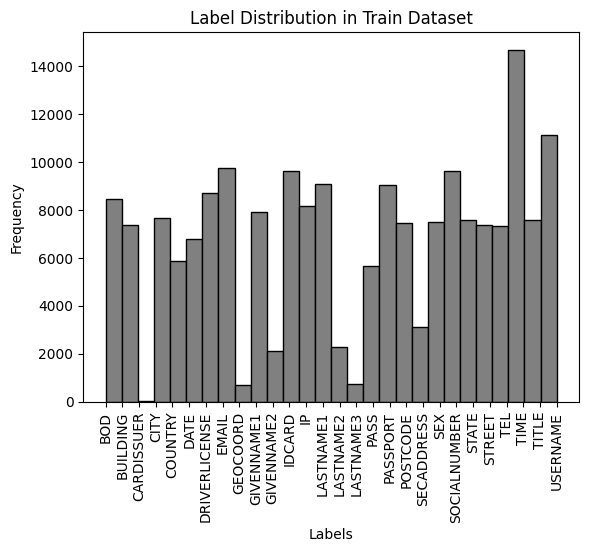

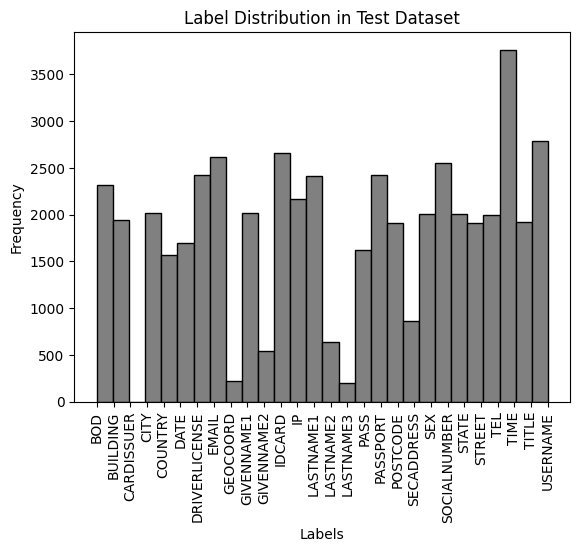

Unique labels: ['BOD', 'BUILDING', 'CARDISSUER', 'CITY', 'COUNTRY', 'DATE', 'DRIVERLICENSE', 'EMAIL', 'GEOCOORD', 'GIVENNAME1', 'GIVENNAME2', 'IDCARD', 'IP', 'LASTNAME1', 'LASTNAME2', 'LASTNAME3', 'PASS', 'PASSPORT', 'POSTCODE', 'SECADDRESS', 'SEX', 'SOCIALNUMBER', 'STATE', 'STREET', 'TEL', 'TIME', 'TITLE', 'USERNAME']


In [15]:
display(df_train.head())

print(f'\nTrain set size: {len(df_train)} / Test set size: {len(df_test)}\n')

def analyze_label_distribution(dataset, dataset_name):
  label_rows = map(lambda data: map(lambda mask: mask['label'], data), dataset['privacy_mask'])
  all_labels = sorted([label for labels in label_rows for label in labels])
  unique_labels = set(all_labels)

  plt.hist(all_labels, bins=len(unique_labels), color='gray', edgecolor='black')
  plt.xlabel('Labels')
  plt.xticks(rotation='vertical')
  plt.ylabel('Frequency')
  plt.title(f'Label Distribution in {dataset_name} Dataset')
  plt.show()

  return sorted(unique_labels)

unique_labels = analyze_label_distribution(df_train, 'Train')
analyze_label_distribution(df_test, 'Test')

print(f'Unique labels: {unique_labels}')

## TODO: Check whether I should implement a filter to remove underrepresented labels,
## like CARDISSUER and GEOCOORD since they are orders of magnitude inferior in number
## and the model may not have enough data to confidently identify these categories

## Could do this by creating a flat-map of all unique tags on a given text, putting all in a list
## like [USERNAME,NAME,DATE], so I could do a search if the to-exclude tags exist in this new column
## and if yes, remove the row (e.g. filter by that)


# Pre-processing

Mapping labels to IDs, getting max length sentence length to use as tensor dimension.

In [29]:
label2id = {k: v for v, k in enumerate(unique_labels)}
id2label = {v: k for v, k in enumerate(unique_labels)}

print('Mapping of labels to IDs:')
print(label2id)

PADDING_TOKEN = '[PAD]'
SENTENCE_START_TOKEN = '[CLS]'
SENTENCE_END_TOKEN = '[SEP]'
MAX_LENGTH = df_train['source_text'].str.len().max()
print(f'\nMaximum sentence length: {MAX_LENGTH}')

def add_labels_for_sentence_tokens(labels):
    labels.insert(0, "O")
    labels.insert(-1, "O")

def pad_to_the_right(tokenized_sentence, labels):
    labels = labels + ["O" for _ in range(MAX_LENGTH - len(labels))]
    return tokenized_sentence + [PADDING_TOKEN for _ in range(MAX_LENGTH - len(tokenized_sentence))]

Mapping of labels to IDs:
{'BOD': 0, 'BUILDING': 1, 'CARDISSUER': 2, 'CITY': 3, 'COUNTRY': 4, 'DATE': 5, 'DRIVERLICENSE': 6, 'EMAIL': 7, 'GEOCOORD': 8, 'GIVENNAME1': 9, 'GIVENNAME2': 10, 'IDCARD': 11, 'IP': 12, 'LASTNAME1': 13, 'LASTNAME2': 14, 'LASTNAME3': 15, 'PASS': 16, 'PASSPORT': 17, 'POSTCODE': 18, 'SECADDRESS': 19, 'SEX': 20, 'SOCIALNUMBER': 21, 'STATE': 22, 'STREET': 23, 'TEL': 24, 'TIME': 25, 'TITLE': 26, 'USERNAME': 27}

Maximum sentence length: 512


# BERT Model

The BERT model to be used is going to be BertForTokenClassification, which is already fine-tuned for the NER task ([doc](https://huggingface.co/docs/transformers/en/model_doc/bert#transformers.BertForTokenClassification)).

The case-sensitive models are being used because personal information dependents a lot on case (e.g.: hunt -> verb, Hunt -> surname).

Padding up tp max length to make sure PyTorch tensors all have the same dimension.

In [10]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
roberta_tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base') #RoBERTa base is case-sensitive

/Users/i530559/Library/Python/3.9/lib/python/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [27]:
%pip install seqeval

from torch.utils.data import Dataset, DataLoader
from seqeval.metrics import classification_report

class MaskingDataset(Dataset):
    
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
    
    def __getitem__(self, i):
        sentence = self.data['source_text'][i] 

        ## TODO: Tokenize sentence!
        # word_labels = self.data
        # tokenized_sentence, labels = self.tokenizer.tokenize()

        tokenized_sentence = [self.SENTENCE_START_TOKEN] + tokenized_sentence + [self.SENTENCE_END_TOKEN]
        add_labels_for_sentence_tokens(labels)
        tokenized_sentence = pad_to_the_right(tokenized_sentence, labels)
        mask = [1 if token != '[PAD]' else 0 for token in tokenized_sentence]
        ids = self.tokenizer.convert_tokens_to_ids(tokenized_sentence)

        label_ids = [label2id[label] for label in labels]
        
        return {
              'ids': torch.tensor(ids, dtype=torch.long),
              'mask': torch.tensor(mask, dtype=torch.long),
              'targets': torch.tensor(label_ids, dtype=torch.long)
        }
        
    def __len__(self):
        return len(self.data)

train_dataset = MaskingDataset(df_train, bert_tokenizer)
test_dataset = MaskingDataset(df_test, bert_tokenizer)